In [1]:
import os

ruta_nueva = 'C:/Users/ruben.morillas/Desktop/aaa/'  
os.chdir(ruta_nueva)

directorio_actual = os.getcwd()
print("Directorio actual:", directorio_actual)

Directorio actual: C:\Users\ruben.morillas\Desktop\aaa


In [2]:
import os
import pandas as pd
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)

In [3]:
import pandas as pd

df_train = pd.read_csv(path_train, index_col=None)


In [4]:
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual, subdirectorio, file_valid)

df_valid = pd.read_csv(path_valid, index_col=None)

In [5]:
df_train = df_train.drop(['trueE'], axis=1)
df_valid = df_valid.drop(['trueE'], axis=1)


Este modulo será el encargado de entrenar los modelos de machine learning y ver los resultados que muetran. Además elegiremos los mejores hiperparametros para los modelos ya que estos modelos serán cargados de la biblioteca Scikit-learn.

Comprobaremos las diferencia de cada modelo para ver que modelo da mejores resultados.

Los modelos que vamos a usar son los siguientes:

*   **Regresión logistica:** Es un modelo lineal que es simple pero eficaz para problemas de clasificación binaria. Este modelo nos dará el punto de partida.

*   **Arboles de decisión:** Es un modelo versatil que puede usarse tanto para clasificación como para regresión. Los arboles de decisión son fáciles de interpretar y pueden capturar relaciones no lineales entre caracterisiticas.

*   **Random Forest:** Un ensamble de arboles de decisión. Es más robusto y preciso que un árbol unico de decisión debido a que reduce el riesgo de sobreajuste mediante el promedio de múltiples árboles

*   **SVM:** Es efectivo en espación de alta dimensión y casos donde el número de dimensiones es mayor que el número de muestras. Es útil tanto para la clasificación lineal como no lineal mediante el uso de diferentes kerneles.

*   **GBM:** Es una técnica de ensamble que construye modelos de forma secuencial, cada nuevo modelo corrige errores del modelo anterior.

*  **k-NN:** Es un modelo simple que clasifica puntos basándose en la mayoría de votos de sus k vecinos más cercanos. Es útil cuando las relaciones entre caracteristicas son complejas y no lineales.

*  **XGBoost:** es una implementación optimizada de árboles de decisión aplicados al algoritmo de Gradient Boosting. Es muy eficaz por su eficiencia en la ejecución.

*   **LightGBM:** es otro algoritmo de Gradient Boosting desarrollado por Microsoft que utiliza árboles basados en histogramas para el modelado.Utiliza la técnica de construcción de árboles basada en histogramas, que agrupa valores continuos en bins discretos



In [6]:
import numpy as np
import pandas as pd

def filtrado_datos(df, N):
    kaones = []
    labels = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]
            grupo_ordenado = grupo_filtrado.head(N)

            # Inicializar arrays para el padding
            hitX_padded = np.zeros(N)
            hitY_padded = np.zeros(N)
            hitZ_padded = np.zeros(N)
            hitInteg_padded = np.zeros(N)

            # Separar y aplicar padding a los valores de hitX, hitY, hitZ, hitInteg
            hitX_padded[:len(grupo_ordenado['hitX'])] = grupo_ordenado['hitX']
            hitY_padded[:len(grupo_ordenado['hitY'])] = grupo_ordenado['hitY']
            hitZ_padded[:len(grupo_ordenado['hitZ'])] = grupo_ordenado['hitZ']
            hitInteg_padded[:len(grupo_ordenado['hitInteg'])] = grupo_ordenado['hitInteg']

            # Concatenar los valores ya con el padding aplicado
            hit_values_reorganized = np.concatenate([hitX_padded, hitY_padded, hitZ_padded, hitInteg_padded])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return np.array(kaones), np.array(labels)


In [7]:
!pip install xgboost lightgbm

Codigo para pintar una matriz de confusion normalizada

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_matriz_confusion_normalizada(conf_matrix, nombre_modelo, class_labels=['Pion', 'Kaon']):
    matriz_conf_normalizada = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_conf_normalizada, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Etiquetas Predecidas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.title('Matriz de confusión '+ nombre_modelo)
    plt.show()

Hacemos un import de todos los modelos que vamos a usar

In [9]:
from sklearn.linear_model import LogisticRegression # Regresión logistica
from sklearn.tree import DecisionTreeClassifier # Arbol de decision
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # SVM
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting Machine
from sklearn.neighbors import KNeighborsClassifier # k-NN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier # LightGBM

Hacemos un import de todas las metricas que vamos a usar

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix


Como hemos indicado en el notebook `estadisticas.ipynb`, para tratar de encontrar el mejor valor de N realizaremos varios entrenamientos con distintos valores de N para ver el comporamiento de los modelos. El valor de N ira en el intervalo [400,800] en saltos de 40. A continuación crearemos el array.

In [11]:
valores_N = np.arange(400,801,40)
valores_N

array([400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800])

Creamos una funcion que pasandole el modelo, los datos de train, las etiquetas de train, devuelve las metricas para validar el modelo

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def train_metrics(modelo, x_train, y_train, x_valid, y_valid):
    modelo.fit(x_train, y_train)
    y_predic = modelo.predict(x_valid)

    # Obtener probabilidades para la clase positiva
    y_proba = modelo.predict_proba(x_valid)[:, 1]  

    # Calculo de métricas de error
    accuracy = accuracy_score(y_valid, y_predic)
    f1 = f1_score(y_valid, y_predic)
    recall = recall_score(y_valid, y_predic)
    roc_auc = roc_auc_score(y_valid, y_proba)  

    return accuracy, f1, recall, roc_auc


In [13]:
from sklearn.base import clone
import time

def metricas_entrenamiento_valores_N(modelo_base, df_train, df_valid, valores_N):
    accuracy_modelo = np.array([])
    f1_modelo = np.array([])
    recall_modelo = np.array([])
    roc_auc_modelo = np.array([])
    tiempo = np.array([])

    for N in valores_N:
        modelo = clone(modelo_base)

        x_train, y_train = filtrado_datos(df_train, N)
        x_valid, y_valid = filtrado_datos(df_valid, N)

        inicio_entrenamiento = time.time()
        print('Inicio de entrenamiento con', N, 'hits por evento')
        accuracy, f1, recall, roc_auc = train_metrics(modelo, x_train, y_train, x_valid, y_valid)
        fin_entrenamiento = time.time()
        print('La duracion del entrenamiento con', N, 'hits por evento es de:', fin_entrenamiento-inicio_entrenamiento)
        
        accuracy_modelo = np.append(accuracy_modelo, accuracy)
        f1_modelo = np.append(f1_modelo, f1)
        recall_modelo = np.append(recall_modelo, recall)
        roc_auc_modelo = np.append(roc_auc_modelo, roc_auc)
        tiempo = np.append(tiempo, fin_entrenamiento-inicio_entrenamiento)

    return accuracy_modelo, f1_modelo, recall_modelo, roc_auc_modelo, tiempo


> **Regresión logisitica (LogisticRegression)** : [documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)


*   **penalty=l2**: debido a que todas las caracteristicas son importantes.
*   **solver='lbfgs'**: Puede manejar problemas de optimización de gran escala de manera más eficiente en términos de memoria. Soporta la regularización l2. Los datos de los que disponemos son datos suaves y relativamente bien comportados por ese motivo puede converger más rapidamente.
*   **random_state=42**: Para la reproducibilidad de los resultados
*   **max_iter=500**: Para que el número máximo de iteraciones que realice no sea mayor de 500
*   **multi_class='ovr'**: ya que es un problema de clasificación binaria



In [14]:
# Cargamos el modelo
## Regresion Logistica
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RL = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=500, multi_class = 'ovr')
accuracy_RL, f1_RL, recall_RL, roc_RL, tiempo_RL = metricas_entrenamiento_valores_N(RL, df_train, df_valid, valores_N)


Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 16.879703998565674
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 17.649405241012573
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 19.133591890335083
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 22.7898588180542
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 23.5298433303833
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 25.475709199905396
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 28.014549255371094
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de:

> **Random Forest Classifier** [documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)

*   **n_estimators=100**: El numero de arboles en la busqueda
*   **criterion='entropy'**: Es más sensible a las diferencias entre las distribuciones de ambas clases. Eso significa que es capaz de identificar divisiones que resulten en una mayor ganancia de informacion, especialmente en casos donde estas diferencias son pequeñas, como pasa en nuestro dataset. El incoveniente es que tienen un mayor coste computacional ya que requiere el uso de logaritmos.
*   **max_depth=None**: Para que los nodos se expandan hasta que todas las hojas sean puras.
*   **max_features=None**: Representa el numero de features para considerar cuando buscamos el mejor separador de clases. Al elegir None hacemos que número maximos de features a elegir sea el numero de features propiamente dicho.
*   **random_state=42**: Para poder reproducir los resultados



In [15]:
RF = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, max_features='sqrt', random_state=42)
accuracy_RF, f1_RF, recall_RF, roc_RF, tiempo_RF = metricas_entrenamiento_valores_N(RF, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 213.7833595275879
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 211.64153170585632
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 218.31554770469666
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 221.7309536933899
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 264.13482546806335
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 326.8933343887329
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 195.9632430076599
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de:

In [16]:
GBC = GradientBoostingClassifier(loss='log_loss', n_estimators=100, criterion='friedman_mse', max_features='sqrt', random_state=42, learning_rate=0.1)
accuracy_GBC, f1_GBC, recall_GBC, roc_GBC, tiempo_GBC = metricas_entrenamiento_valores_N(GBC, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 88.85838961601257
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 88.13033366203308
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 89.22990036010742
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 90.24861764907837
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 90.96299767494202
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 90.00861620903015
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 90.03110909461975
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de: 90

In [17]:
SVM_model = SVC(kernel='rbf', gamma='scale', random_state=42, probability=True)
accuracy_SVM, f1_SVM, recall_SVM, roc_SVM, tiempo_SVM = metricas_entrenamiento_valores_N(SVM_model, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 2762.8323545455933
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 2838.2053310871124
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 3062.415859222412
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 3282.642688035965
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 3538.4153361320496
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 3787.1996099948883
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 4028.2715458869934
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es d

In [18]:
DTC = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
accuracy_DTC, f1_DTC, recall_DTC, roc_DTC, tiempo_DTC = metricas_entrenamiento_valores_N(DTC, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 292.0995514392853
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 312.30772280693054
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 309.4076521396637
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 306.4941325187683
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 320.55036640167236
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 318.127521276474
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 330.0574269294739
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de: 3

In [19]:
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
accuracy_KNN, f1_KNN, recall_KNN, roc_KNN, tiempo_KNN = metricas_entrenamiento_valores_N(KNN, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 14.596641063690186
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 15.835829734802246
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 17.07243251800537
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 18.403331995010376
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 19.793286561965942
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 24.023160696029663
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 25.206777811050415
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es 

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import xgboost as xgb
import time

# Listas para almacenar las métricas
accuracy_XGB = []
f1_XGB = []
recall_XGB = []
roc_XGB = []
tiempo_XGB = []

# Iterar sobre los diferentes tamaños de datos
for N in valores_N:
    # Obtener datos de entrenamiento y validación
    X_train, y_train = filtrado_datos(df_train, N)
    X_valid, y_valid = filtrado_datos(df_valid, N)
    
    # Definir los parámetros del modelo
    params = {
        'booster': 'gbtree',
        'max_depth': 6,
        'gamma': 0,
        'learning_rate': 0.3,
        'subsample': 1,
        'colsample_bytree': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42
    }
    
    num_epochs = 100
    
    # Entrenar el modelo y medir el tiempo de entrenamiento
    inicio_entrenamiento = time.time()
    xgb_model = xgb.XGBClassifier(**params, n_estimators=num_epochs)
    xgb_model.fit(X_train, y_train)
    fin_entrenamiento = time.time()
    
    # Registrar el tiempo de entrenamiento
    tiempo_entrenamiento = fin_entrenamiento - inicio_entrenamiento
    tiempo_XGB.append(tiempo_entrenamiento)
    
    # Realizar predicciones en el conjunto de validación
    y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
    y_pred = np.round(y_pred_proba)
    
    # Calcular métricas de evaluación
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    
    # Almacenar métricas en las listas correspondientes
    accuracy_XGB.append(accuracy)
    f1_XGB.append(f1)
    recall_XGB.append(recall)
    roc_XGB.append(roc_auc)


In [21]:
lgbm = LGBMClassifier(boosting_type='gbdt', max_depth=6, learning_rate=0.3, subsample=1, colsample_bytree=1, random_state=42)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
accuracy_LGBM, f1_LGBM, recall_LGBM, roc_LGBM, tiempo_LGBM = metricas_entrenamiento_valores_N(lgbm, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13963, number of negative: 13652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.577378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408000
[LightGBM] [Info] Number of data points in the train set: 27615, number of used features: 1600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505631 -> initscore=0.022525
[LightGBM] [Info] Start training from score 0.022525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

### Metricas de cada modelo

In [22]:
import matplotlib.pyplot as plt

def graficar_metricas(valores_N, accuracy, f1, recall, roc_auc, titulo):
    plt.figure(figsize=(10, 6))

    # Graficar las métricas en la misma gráfica
    plt.plot(valores_N, accuracy, label='Accuracy', marker='_', color='blue')
    plt.plot(valores_N, f1, label='F1 Score', marker='_', color='green')
    plt.plot(valores_N, recall, label='Recall', marker='_', color='red')
    plt.plot(valores_N, roc_auc, label='ROC AUC', marker='_', color='purple')

    plt.title('Métricas de Evaluación en función de N ' + titulo)
    plt.xlabel('N')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)

    min_y = 0.7   
    max_y = 1   
    plt.ylim(min_y, max_y)
    plt.yticks(np.arange(min_y, max_y, 0.05))

    plt.show()



In [23]:
import matplotlib.pyplot as plt

def comparar_metricas_modelos(valores_N, metrica1, metrica2, metrica3, metrica4, metrica5, metrica6, metrica7, metrica8, titulo):
    plt.figure(figsize=(10, 6))

    # Graficar las métricas en la misma gráfica
    plt.plot(valores_N, metrica1, label='Regresion Logistica', marker='_')
    plt.plot(valores_N, metrica2, label='Random Forest', marker='_')
    plt.plot(valores_N, metrica3, label='Decision Tree', marker='_')
    plt.plot(valores_N, metrica4, label='SVM', marker='_')
    plt.plot(valores_N, metrica5, label='Gradient Boosting', marker='_')
    plt.plot(valores_N, metrica6, label='KNN', marker='_')
    plt.plot(valores_N, metrica7, label='XGBost', marker='_')
    plt.plot(valores_N, metrica8, label='LightGBM', marker='_')



    plt.title('Comparacion de '+titulo+ ' de los diferentes modelos')
    plt.xlabel('N')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)

    min_y = 0.7
    max_y = 1   
    plt.ylim(min_y, max_y)
    plt.yticks(np.arange(min_y, max_y, 0.05))

    plt.show()


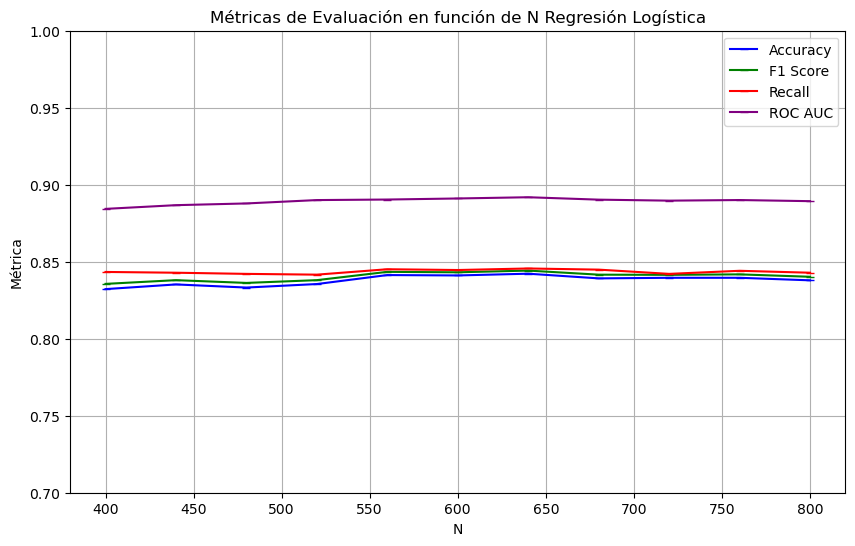

In [24]:
graficar_metricas(valores_N, accuracy_RL, f1_RL, recall_RL, roc_RL, titulo='Regresión Logística')

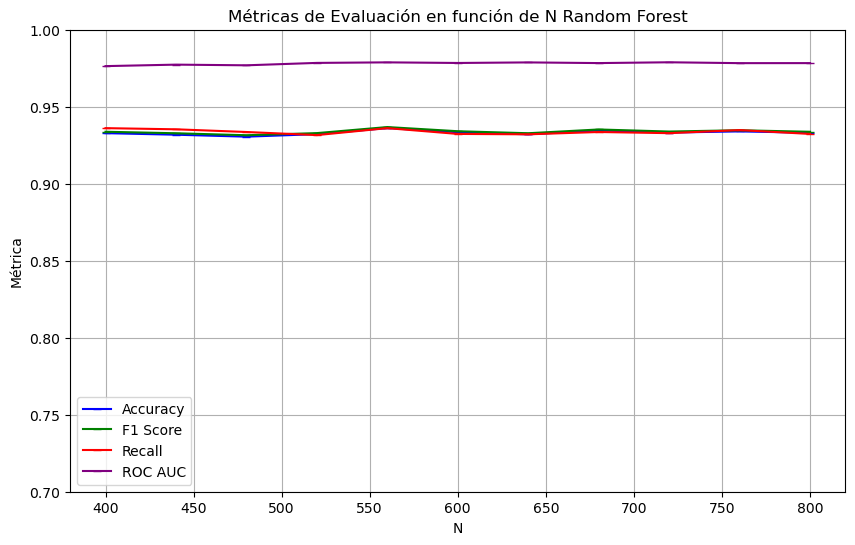

In [25]:
graficar_metricas(valores_N, accuracy_RF, f1_RF, recall_RF, roc_RF, titulo='Random Forest')

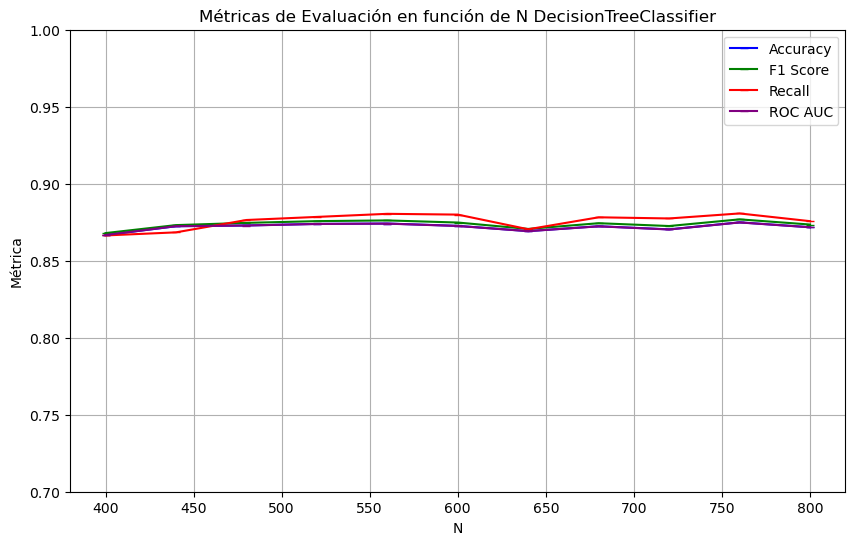

In [26]:
graficar_metricas(valores_N, accuracy_DTC, f1_DTC, recall_DTC, roc_DTC, titulo='DecisionTreeClassifier')

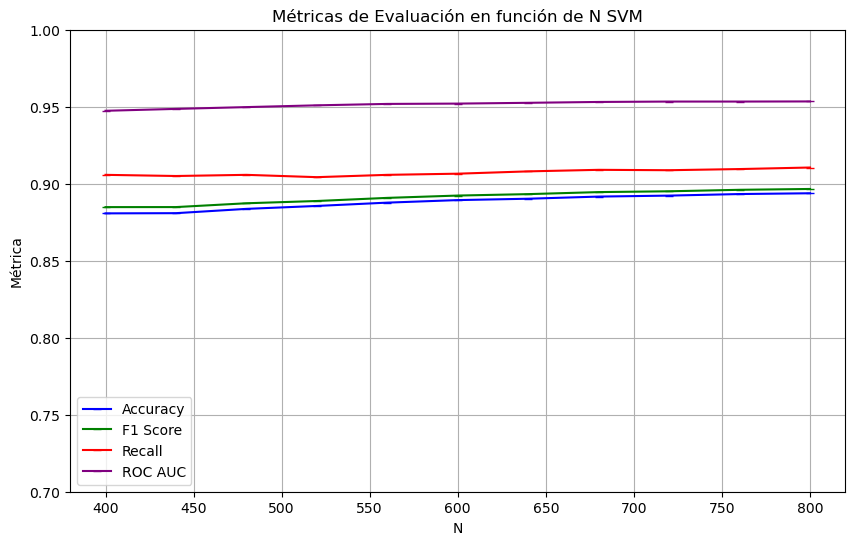

In [27]:
graficar_metricas(valores_N, accuracy_SVM, f1_SVM, recall_SVM, roc_SVM, titulo='SVM')

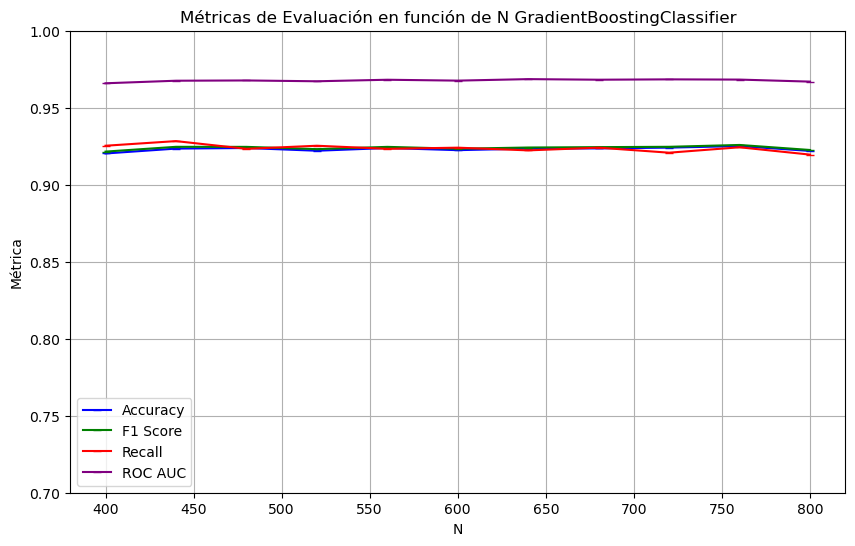

In [28]:
graficar_metricas(valores_N, accuracy_GBC, f1_GBC, recall_GBC, roc_GBC, titulo='GradientBoostingClassifier')

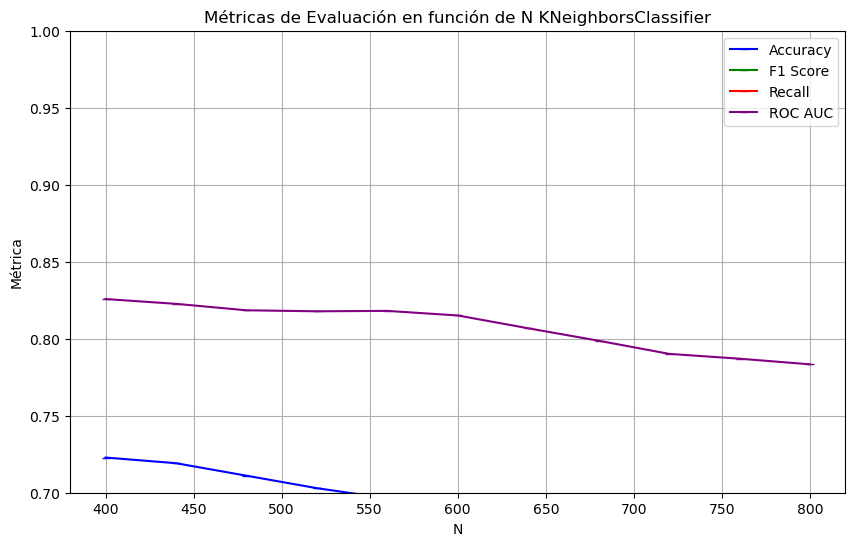

In [29]:
graficar_metricas(valores_N, accuracy_KNN, f1_KNN, recall_KNN, roc_KNN, titulo='KNeighborsClassifier')

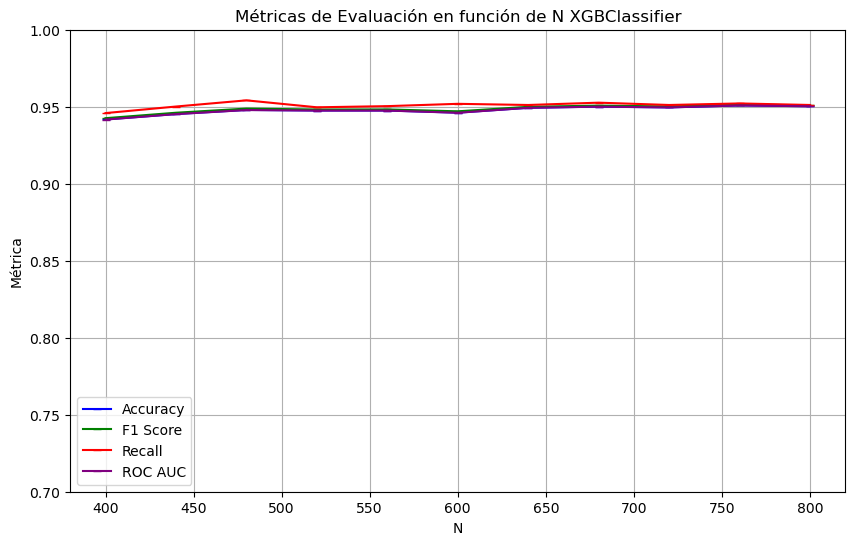

In [30]:
graficar_metricas(valores_N, accuracy_XGB, f1_XGB, recall_XGB, roc_XGB, titulo='XGBClassifier')

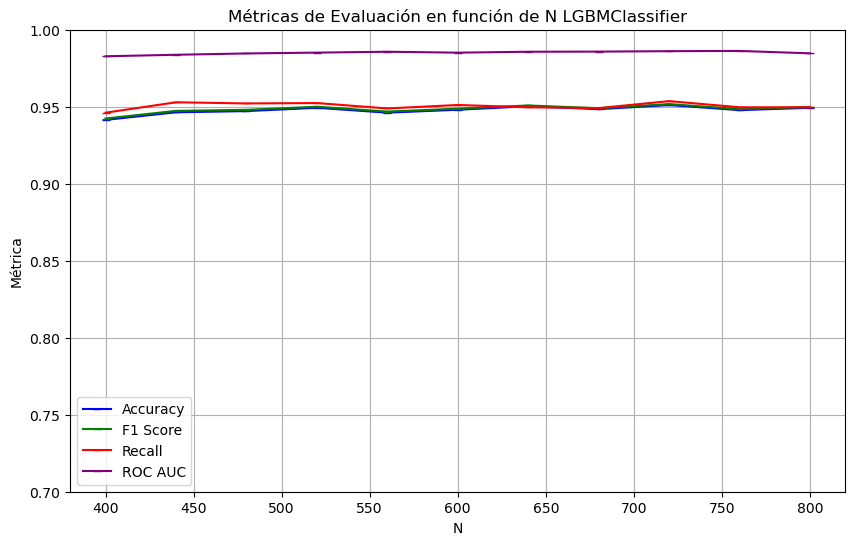

In [31]:
graficar_metricas(valores_N, accuracy_LGBM, f1_LGBM, recall_LGBM, roc_LGBM, titulo='LGBMClassifier')

## Comparativa de metricas

In [44]:
def print_metricas(modelo, metrica, valores_N):
    print(modelo)
    print('Valor maximo:', np.max(metrica))
    indice_max = np.argmax(metrica)
    print('N MAX:',valores_N[indice_max])
    print('Valor minimo:', np.min(metrica))
    indice_min = np.argmin(metrica)
    print('N MIN:', valores_N[indice_min])
    print('Diferencia:', np.max(metrica) - np.min(metrica))

print_metricas('Regresion Logisitica', accuracy_RL, valores_N)
print()
print_metricas('Random Forest', accuracy_RF, valores_N)
print()
print_metricas('Decision Tree', accuracy_DTC, valores_N)
print()
print_metricas('SVM', accuracy_SVM, valores_N)
print()
print_metricas('Gradient Boosting', accuracy_GBC, valores_N)
print()
print_metricas('KNN', accuracy_KNN, valores_N)
print()
print_metricas('XGBoost',accuracy_XGB, valores_N)
print()
print_metricas('LightGBM', accuracy_LGBM, valores_N)
print()

Regresion Logisitica
Valor maximo: 0.8422253199847928
N MAX: 640
Valor minimo: 0.8322139145862375
N MIN: 400
Diferencia: 0.010011405398555273

Random Forest
Valor maximo: 0.9361297680902294
N MAX: 560
Valor minimo: 0.930553795463186
N MIN: 480
Diferencia: 0.005575972627043457

Decision Tree
Valor maximo: 0.8749207958433659
N MAX: 760
Valor minimo: 0.8666835635534152
N MIN: 400
Diferencia: 0.008237232289950658

SVM
Valor maximo: 0.8938030667849449
N MAX: 800
Valor minimo: 0.8807502217716385
N MIN: 400
Diferencia: 0.013052845013306391

Gradient Boosting
Valor maximo: 0.925104549486757
N MAX: 760
Valor minimo: 0.9202889367634013
N MIN: 400
Diferencia: 0.004815612723355733

KNN
Valor maximo: 0.7228488151058168
N MAX: 400
Valor minimo: 0.6574578633886706
N MIN: 800
Diferencia: 0.06539095171714615

XGBoost
Valor maximo: 0.9508300595615258
N MAX: 760
Valor minimo: 0.9417057407172729
N MIN: 400
Diferencia: 0.00912431884425291

LightGBM
Valor maximo: 0.951083512862755
N MAX: 720
Valor minimo: 0

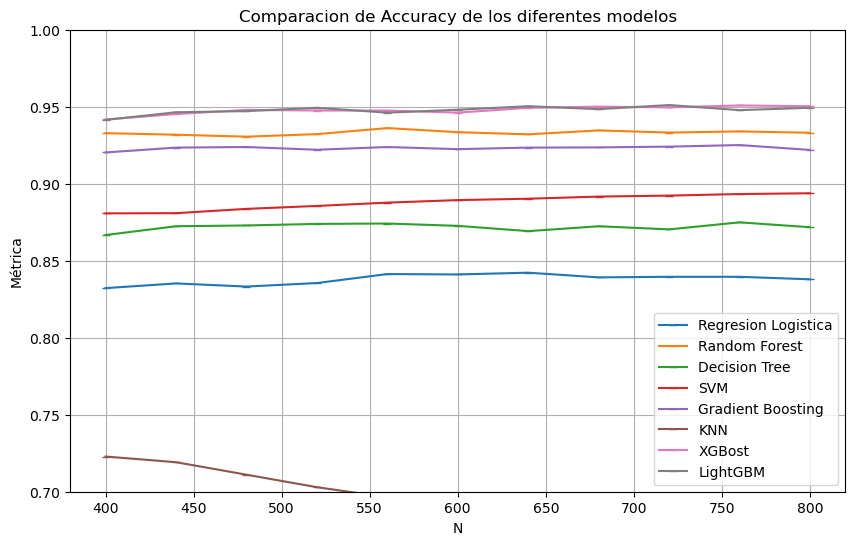

In [33]:
comparar_metricas_modelos(valores_N, accuracy_RL, accuracy_RF, accuracy_DTC, accuracy_SVM, accuracy_GBC, accuracy_KNN, accuracy_XGB, accuracy_LGBM, 'Accuracy')

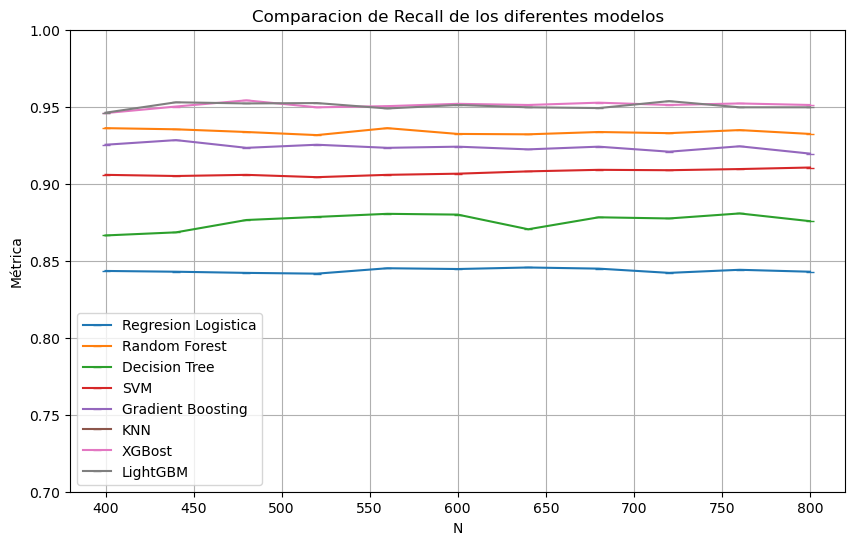

In [34]:
comparar_metricas_modelos(valores_N, recall_RL, recall_RF, recall_DTC, recall_SVM, recall_GBC, recall_KNN, recall_XGB, recall_LGBM, 'Recall')

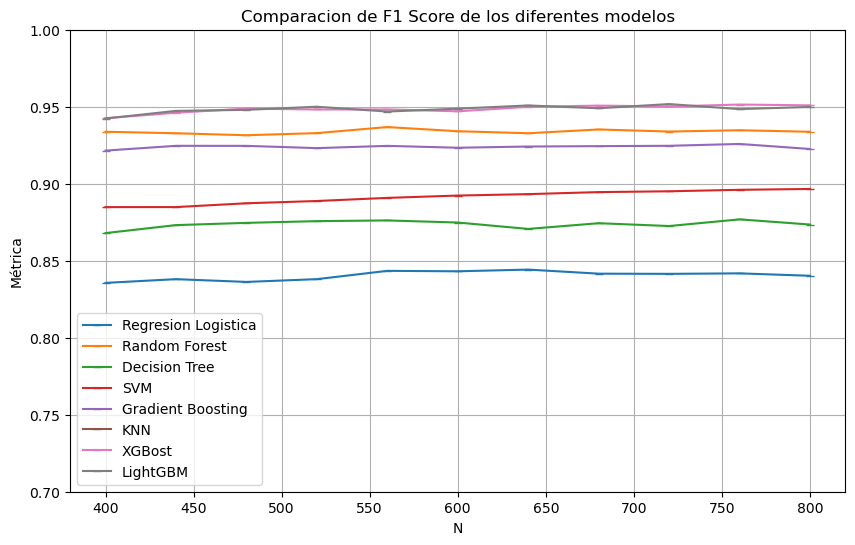

In [35]:
comparar_metricas_modelos(valores_N, f1_RL, f1_RF, f1_DTC, f1_SVM, f1_GBC, f1_KNN, f1_XGB, f1_LGBM, 'F1 Score')

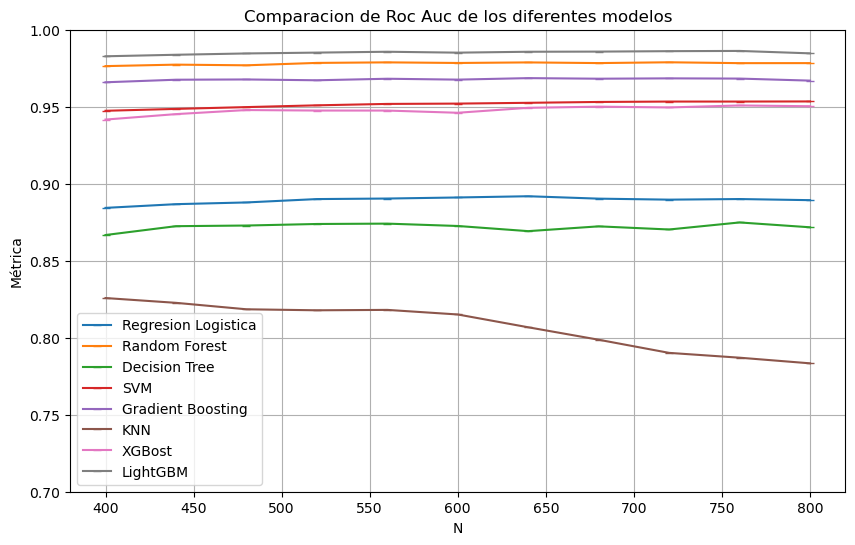

In [36]:
comparar_metricas_modelos(valores_N, roc_RL, roc_RF, roc_DTC, roc_SVM, roc_GBC, roc_KNN, roc_XGB, roc_LGBM, 'Roc Auc')

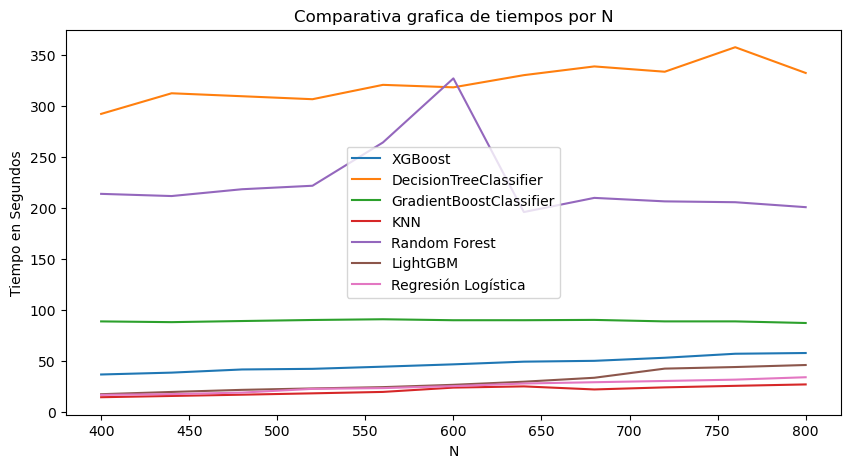

In [37]:
plt.figure(figsize=(10,5))
plt.plot(valores_N,tiempo_XGB, label = 'XGBoost')
plt.plot(valores_N,tiempo_DTC, label = 'DecisionTreeClassifier')
plt.plot(valores_N,tiempo_GBC, label='GradientBoostClassifier')
plt.plot(valores_N,tiempo_KNN, label='KNN')
plt.plot(valores_N,tiempo_RF, label='Random Forest')
plt.plot(valores_N,tiempo_LGBM, label='LightGBM')
# plt.plot(valores_N,tiempo_SVM, label='SVM')
plt.plot(valores_N,tiempo_RL, label='Regresión Logística')
plt.title('Comparativa grafica de tiempos por N')
plt.xlabel('N')
plt.ylabel('Tiempo en Segundos')
plt.legend()
plt.show()


## Eleccion de las mejores N

Los mejores modelos según las métricas anteriores son los siguientes:
*   **LGBM**
*   **Random Forest**
*   **GBC**
*   **XGB**

Por tanto elegiremos los mejores valores de N para cada modelo según sus métricas:    

In [38]:
def mejor_N(accuracy, recall, f1, roc, valores_N):
    mejor_accuracy = max(accuracy)
    mejor_recall = max(recall)
    mejor_f1 = max(f1)
    mejor_roc = max(roc)

    indice_mejor_accuracy = np.argmax(accuracy)
    indice_mejor_recall = np.argmax(recall)
    indice_mejor_f1 = np.argmax(f1)
    indice_mejor_roc = np.argmax(roc)

    indices_interseccion = set([indice_mejor_accuracy, indice_mejor_recall, indice_mejor_f1, indice_mejor_roc])

    mejor_N = valores_N[list(indices_interseccion)[0]]

    return mejor_N


In [39]:
# calculamos los distintos N para los 4 modelos
N_XGB = mejor_N(accuracy_XGB, recall_XGB, f1_XGB, roc_XGB, valores_N)
N_GBC = mejor_N(accuracy_GBC, recall_GBC, f1_GBC, roc_GBC, valores_N)
N_RF = mejor_N(accuracy_RF, recall_RF, f1_RF, roc_RF, valores_N)
N_LGBM = mejor_N(accuracy_LGBM, recall_LGBM, f1_LGBM, roc_LGBM, valores_N)


print('El mejor N de XGB es:', N_XGB, 'hits por eventos')
print('El mejor N de GBC es:', N_GBC, 'hits por eventos')
print('El mejor N de RF es:', N_RF, 'hits por eventos')
print('El mejor N de LGBM es:', N_LGBM, 'hits por eventos')


El mejor N de XGB es: 760 hits por eventos
El mejor N de GBC es: 760 hits por eventos
El mejor N de RF es: 400 hits por eventos
El mejor N de LGBM es: 720 hits por eventos


### Matrices de confusion de los 4 modelos

En esta sección pintaremos la matriz de confusion de los 4 modelos para ver los resultados que obtenemos. Cada modelo será entrenado con la mejor N

##### LGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13963, number of negative: 13652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.155391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734400
[LightGBM] [Info] Number of data points in the train set: 27615, number of used features: 2880
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505631 -> initscore=0.022525
[LightGBM] [Info] Start training from score 0.022525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


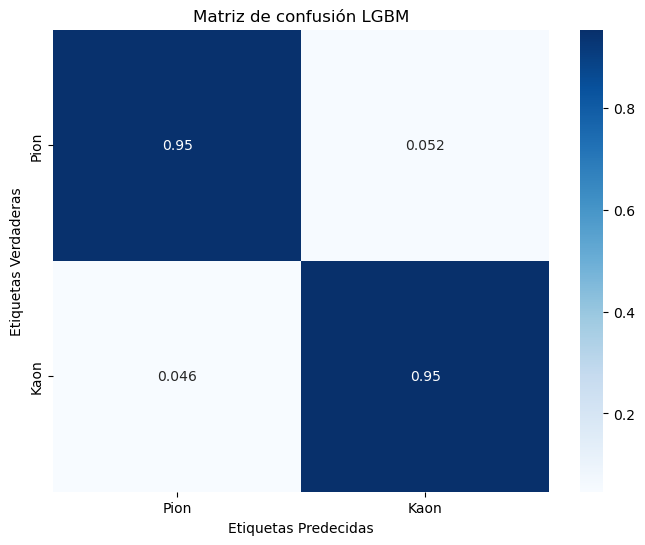

In [40]:
# Cargamos el modelo
N_LGBM = 720
lgbm = LGBMClassifier(boosting_type='gbdt', max_depth=6, learning_rate=0.3, subsample=1, colsample_bytree=1, random_state=42)
x_train, y_train = filtrado_datos(df_train, N_LGBM)
x_valid, y_valid = filtrado_datos(df_valid, N_LGBM)
lgbm.fit(x_train, y_train)
y_predict = lgbm.predict(x_valid)
matriz_lgbm = confusion_matrix(y_valid, y_predict)
plot_matriz_confusion_normalizada(matriz_lgbm, nombre_modelo='LGBM')



##### RF

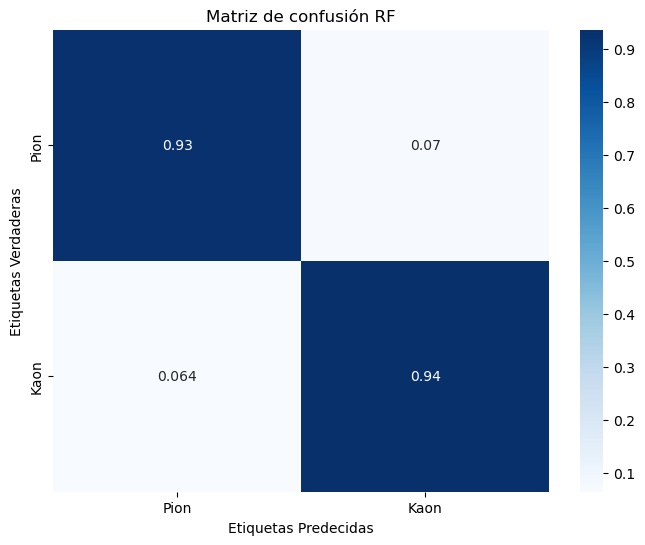

In [41]:
N_RF = 400
RF = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, max_features='sqrt', random_state=42)
x_train, y_train = filtrado_datos(df_train, N_RF)
x_valid, y_valid = filtrado_datos(df_valid, N_RF)
RF.fit(x_train, y_train)
y_predict = RF.predict(x_valid)
matriz_rf = confusion_matrix(y_valid, y_predict)
plot_matriz_confusion_normalizada(matriz_rf, nombre_modelo='RF')


##### GBC

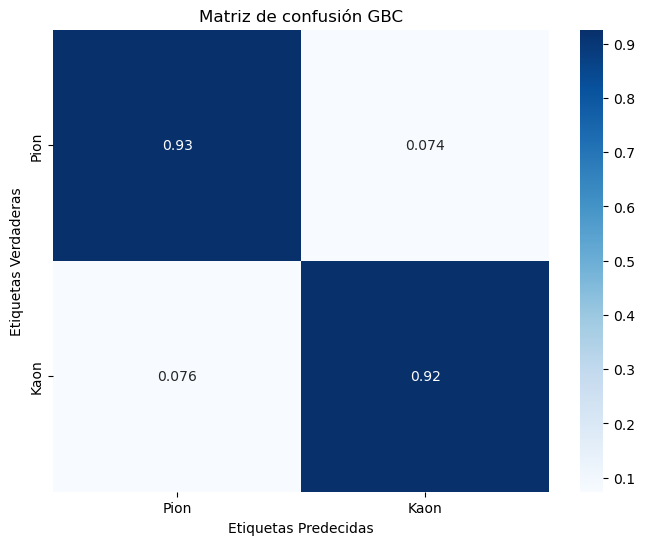

In [42]:
N_GBC = 760
GBC = GradientBoostingClassifier(loss='log_loss', n_estimators=100, criterion='friedman_mse', max_features='sqrt', random_state=42, learning_rate=0.1)
x_train, y_train = filtrado_datos(df_train, N_GBC)
x_valid, y_valid = filtrado_datos(df_valid, N_GBC)
GBC.fit(x_train, y_train)
y_predict = GBC.predict(x_valid)
matriz_gbc = confusion_matrix(y_valid, y_predict)
plot_matriz_confusion_normalizada(matriz_gbc, nombre_modelo='GBC')


##### XGB

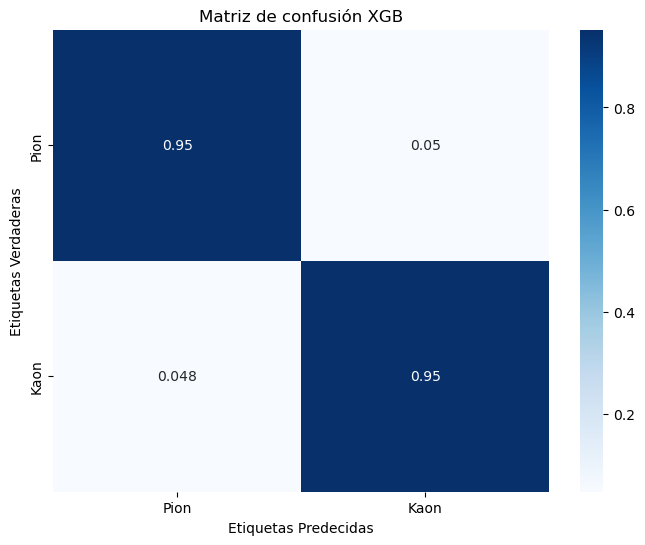

In [43]:
N_XGB=760
x_train, y_train = filtrado_datos(df_train, N_XGB)
x_valid, y_valid = filtrado_datos(df_valid, N_XGB)

params = {
    'booster': 'gbtree',
    'max_depth': 6,
    'gamma': 0,
    'learning_rate': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  
    'seed': 42
}

num_epochs = 100

# Crear el modelo XGBoost
xgb = XGBClassifier(**params, n_estimators=num_epochs)

# Entrenar el modelo
xgb.fit(x_train, y_train)

# Predecir en el conjunto de validación
y_predict = xgb.predict(x_valid)

# Calcular la matriz de confusión
matriz_xgb = confusion_matrix(y_valid, y_predict)


plot_matriz_confusion_normalizada(matriz_xgb, nombre_modelo='XGB')
